In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# ==========================================
# 1. 读取微观数据 (C++ Results)
# ==========================================
print("正在读取微观模拟 CSV 文件...")

file = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_total.csv'
file_r1 = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_K1.csv'
file_r2 = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_K2.csv'

# 假设 CSV 的第一行是 p 值，第一列是 rate 值
try:
    df_total = pd.read_csv(file, index_col=0)      # 总体 |Z|
    df_k1 = pd.read_csv(file_r1, index_col=0)      # K1 群体 |Z_1| (负耦合)
    df_k2 = pd.read_csv(file_r2, index_col=0)      # K2 群体 |Z_2| (正耦合)
except FileNotFoundError:
    print("错误：未找到 CSV 文件，请确保文件名正确并已上传。")
    raise

# 提取网格参数 (直接从 CSV 读取，确保与 C++ 一致)
# index 是 rate (纵轴), columns 是 p (横轴)
rate_vals = df_total.index.astype(float).values
p_vals = df_total.columns.astype(float).values

# 提取矩阵数据 (Microscopic)
# 注意：pandas读取后，values[i, j] 对应 row[i], col[j]
R_micro = df_total.values
R1_micro = df_k1.values
R2_micro = df_k2.values

N_rows, N_cols = R_micro.shape
print(f"数据加载成功: 网格大小 {N_rows}x{N_cols}")
print(f"Rate范围: {rate_vals.min():.4f} - {rate_vals.max():.4f}")
print(f"P范围:    {p_vals.min():.4f} - {p_vals.max():.4f}")

# ==========================================
# 2. 计算解析解 (Theoretical Results)
# ==========================================

# --- 动力学方程定义 (同前) ---
def dzdt_latex_defined(z, t, p, K1, K2, gamma, r1, r2):
    z1, z2 = z[0], z[1]
    q = 1.0 - p
    Z = q * z1 + p * z2
    Z_conj = np.conjugate(Z)
    eps = 1e-12
    p_safe = max(p, eps)
    q_safe = max(q, eps)
    
    dz1 = -gamma * z1 - (K1 / 2.0) * Z * (z1**2) + (K1 / 2.0) * Z_conj + r1 * (p_safe / q_safe) * (z2 - z1)
    dz2 = -gamma * z2 - (K2 / 2.0) * Z * (z2**2) + (K2 / 2.0) * Z_conj + r2 * (q_safe / p_safe) * (z1 - z2)
    return np.array([dz1, dz2], dtype=complex)

def rk4_step(z, t, dt, f, p, K1, K2, gamma, r1, r2):
    k1 = f(z, t, p, K1, K2, gamma, r1, r2)
    k2 = f(z + 0.5 * dt * k1, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k3 = f(z + 0.5 * dt * k2, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k4 = f(z + dt * k3, t + dt, p, K1, K2, gamma, r1, r2)
    return z + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def get_steady_state(p, total_rate, K1, K2, gamma, seed):
    # 稳态 r1, r2
    r2 = p * total_rate
    r1 = (1.0 - p) * total_rate
    
    # 随机初值
    np.random.seed(seed)
    z = (np.random.rand(2) + 1j * np.random.rand(2)) * 0.01
    
    dt = 0.05
    t_max = 300.0
    check_interval = 2.0
    last_abs_z = np.abs(z)
    
    t = 0
    while t < t_max:
        steps = int(check_interval/dt)
        for _ in range(steps):
            z = rk4_step(z, t, dt, dzdt_latex_defined, p, K1, K2, gamma, r1, r2)
            t += dt
            if np.abs(z[0]) > 10: return 10, 10, 10 # 发散保护
            
        curr_abs_z = np.abs(z)
        if np.max(np.abs(curr_abs_z - last_abs_z)) < 1e-5:
            break
        last_abs_z = curr_abs_z
        
    q = 1.0 - p
    Z = q * z[0] + p * z[1]
    return np.abs(Z), np.abs(z[0]), np.abs(z[1])

# --- 开始计算 ---
print("\n开始计算解析解以进行对比...")
K1, K2 = -0.5, 1.0
gamma = 0.05

R_theory = np.zeros_like(R_micro)
R1_theory = np.zeros_like(R1_micro)
R2_theory = np.zeros_like(R2_micro)

start_time = time.time()

# 遍历 CSV 提供的网格点
for i, rate in enumerate(rate_vals):
    for j, p in enumerate(p_vals):
        # 使用相同的参数计算理论值
        # seed 保证可重复性
        seed = (i * N_cols + j) % 10000
        R, R1, R2 = get_steady_state(p, rate, K1, K2, gamma, seed)
        
        R_theory[i, j] = R
        R1_theory[i, j] = R1
        R2_theory[i, j] = R2

    if i % 5 == 0:
        print(f"理论计算进度: {i}/{N_rows} 行")

print(f"理论计算完成，耗时: {time.time() - start_time:.2f}s")

正在读取微观模拟 CSV 文件...
数据加载成功: 网格大小 30x30
Rate范围: 0.0010 - 1.0000
P范围:    0.3000 - 0.9500

开始计算解析解以进行对比...
理论计算进度: 0/30 行
理论计算进度: 5/30 行
理论计算进度: 10/30 行
理论计算进度: 15/30 行
理论计算进度: 20/30 行
理论计算进度: 25/30 行
理论计算完成，耗时: 19.54s


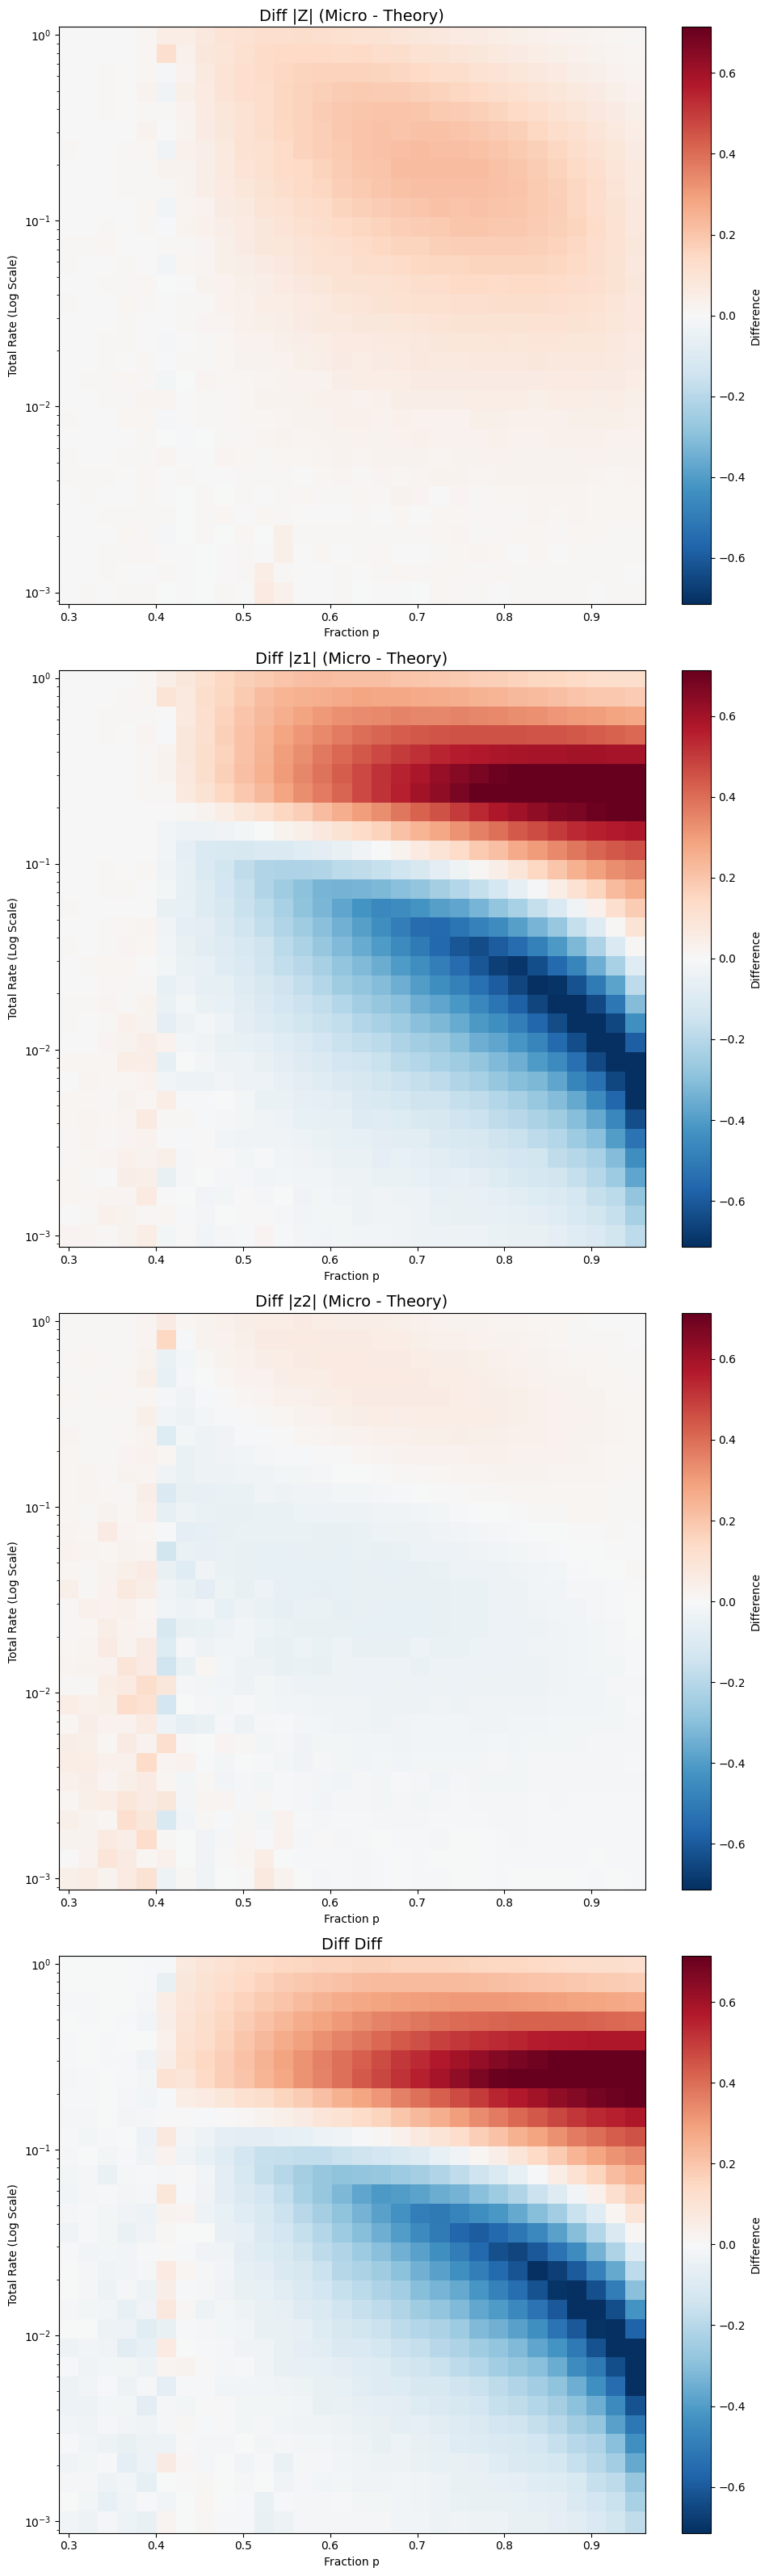

In [3]:
# ==========================================
# 3. 计算误差并绘图
# ==========================================
# 误差定义: Micro - Theory
Diff_Total = R_micro - R_theory
Diff_K1 = R1_micro - R1_theory
Diff_K2 = R2_micro - R2_theory
Diff_diff = Diff_K1 - Diff_K2

# 找出最大误差幅度，用于设置颜色范围对称
max_diff = max(np.max(np.abs(Diff_Total)), np.max(np.abs(Diff_K1)), np.max(np.abs(Diff_K2)))
clim = max_diff * 0.8 #稍微缩一点范围让颜色更明显

plt.figure(figsize=(10, 32))

# 设置绘图范围
extent = [p_vals[0], p_vals[-1], rate_vals[0], rate_vals[-1]]

# 使用对数纵坐标时，imshow 需要特殊处理
# 因为 rate 是对数的，直接 imshow 会线性拉伸。
# 这种情况下，建议用 pcolormesh 获得物理上正确的轴，或者修改 imshow 的纵横比
# 这里使用 pcolormesh 以准确反映对数轴

# 构建网格 (pcolormesh 需要网格边缘，这里简单用中心点网格)
P_grid, Rate_grid = np.meshgrid(p_vals, rate_vals)

# 绘图辅助函数
def plot_heatmap(ax, data, title, cmap='RdBu_r'):
    # 使用 pcolormesh 处理对数坐标
    # shading='auto' or 'nearest'
    im = ax.pcolormesh(P_grid, Rate_grid, data, cmap=cmap, vmin=-clim, vmax=clim, shading='nearest')
    ax.set_yscale('log') # 设置纵轴为对数
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Fraction p')
    ax.set_ylabel('Total Rate (Log Scale)')
    return im

# 1. Total |Z| Difference
ax1 = plt.subplot(4, 1, 1)
im1 = plot_heatmap(ax1, Diff_Total, 'Diff |Z| (Micro - Theory)')
plt.colorbar(im1, ax=ax1, label='Difference')

# 2. |z1| Difference (Negative Coupling)
ax2 = plt.subplot(4, 1, 2)
im2 = plot_heatmap(ax2, Diff_K1, 'Diff |z1| (Micro - Theory)')
plt.colorbar(im2, ax=ax2, label='Difference')

# 3. |z2| Difference (Positive Coupling)
ax3 = plt.subplot(4, 1, 3)
im3 = plot_heatmap(ax3, Diff_K2, 'Diff |z2| (Micro - Theory)')
plt.colorbar(im3, ax=ax3, label='Difference')

# 4. Difference Difference 
ax4 = plt.subplot(4, 1, 4)
im4 = plot_heatmap(ax4, Diff_diff, 'Diff Diff')
plt.colorbar(im4, ax=ax4, label='Difference')

plt.tight_layout()
plt.show()

# 保存误差数据
# np.savez('error_analysis.npz', 
#          diff_total=Diff_Total, 
#          diff_k1=Diff_K1, 
#          diff_k2=Diff_K2,
#          p_vals=p_vals,
#          rate_vals=rate_vals)
#print("误差数据已保存至 error_analysis.npz")

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ==========================================
# 1. 动力学方程与求解器 (用于生成完全匹配的理论数据)
# ==========================================
# 固定参数
K1, K2 = -0.5, 1.0
gamma = 0.05

def dzdt_latex_defined(z, t, p, K1, K2, gamma, r1, r2):
    """根据 LaTeX 公式计算 dz/dt"""
    z1, z2 = z[0], z[1]
    q = 1.0 - p
    Z = q * z1 + p * z2
    Z_conj = np.conjugate(Z)
    eps = 1e-12
    p_safe = max(p, eps)
    q_safe = max(q, eps)
    
    # dz1: -gamma*z1 - (K1/2)*Z*z1^2 + (K1/2)*Z^* + r1*(p/q)*(z2-z1)
    dz1 = -gamma * z1 - (K1 / 2.0) * Z * (z1**2) + (K1 / 2.0) * Z_conj + r1 * (p_safe / q_safe) * (z2 - z1)
    # dz2: -gamma*z2 - (K2/2)*Z*z2^2 + (K2/2)*Z^* + r2*(q/p)*(z1-z2)
    dz2 = -gamma * z2 - (K2 / 2.0) * Z * (z2**2) + (K2 / 2.0) * Z_conj + r2 * (q_safe / p_safe) * (z1 - z2)
    return np.array([dz1, dz2], dtype=complex)

def rk4_step(z, t, dt, f, p, K1, K2, gamma, r1, r2):
    k1 = f(z, t, p, K1, K2, gamma, r1, r2)
    k2 = f(z + 0.5 * dt * k1, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k3 = f(z + 0.5 * dt * k2, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k4 = f(z + dt * k3, t + dt, p, K1, K2, gamma, r1, r2)
    return z + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def get_steady_state(p, total_rate, K1, K2, gamma, seed):
    """对给定的 p 和 rate，从微小随机值演化直到稳态"""
    r2 = p * total_rate
    r1 = (1.0 - p) * total_rate
    
    np.random.seed(seed)
    z = (np.random.rand(2) + 1j * np.random.rand(2)) * 0.01
    
    dt = 0.05
    t_max = 300.0
    check_interval = 2.0
    last_abs_z = np.abs(z)
    
    t = 0
    steps_per_check = int(check_interval / dt)
    
    while t < t_max:
        for _ in range(steps_per_check):
            z = rk4_step(z, t, dt, dzdt_latex_defined, p, K1, K2, gamma, r1, r2)
            t += dt
            if np.abs(z[0]) > 10: return 10.0, 10.0, 10.0 # 发散保护
            
        curr_abs_z = np.abs(z)
        if np.max(np.abs(curr_abs_z - last_abs_z)) < 1e-5: # 模长变化极小即为稳态
            break
        last_abs_z = curr_abs_z
        
    q = 1.0 - p
    Z = q * z[0] + p * z[1]
    return np.abs(Z), np.abs(z[0]), np.abs(z[1])

# ==========================================
# 2. 读取微观数据并计算理论值
# ==========================================


file = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_total.csv'
file_r1 = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_K1.csv'
file_r2 = '/Users/xiroihs/Documents/K+K- shift/序参量随速率与比例/output_3/scan_R_K2.csv'

# 假设 CSV 的第一行是 p 值，第一列是 rate 值
try:
    df_total_micro_raw  = pd.read_csv(file, index_col=0)      # 总体 |Z|
    df_k1_micro_raw  = pd.read_csv(file_r1, index_col=0)      # K1 群体 |Z_1| (负耦合)
    df_k2_micro_raw  = pd.read_csv(file_r2, index_col=0)      # K2 群体 |Z_2| (正耦合)
except FileNotFoundError:
    print("错误：未找到 CSV 文件，请确保文件名正确并已上传。")
    raise


# 提取网格坐标 (以微观数据为准，确保精确匹配)
rate_axis = df_total_micro_raw.index.astype(float).values
p_axis    = df_total_micro_raw.columns.astype(float).values

N_rows, N_cols = df_total_micro_raw.shape
print(f"网格参数提取成功: {N_rows}x{N_cols}")

# --- 现场计算理论值 (Theoretical Calculation) ---
print("\n开始计算理论解以精确匹配微观网格...")

R_th, R1_th, R2_th = np.zeros((N_rows, N_cols)), np.zeros((N_rows, N_cols)), np.zeros((N_rows, N_cols))
start_time = time.time()

for i, rate in enumerate(rate_axis):
    for j, p in enumerate(p_axis):
        seed = (i * N_cols + j) % 10000
        R, R1, R2 = get_steady_state(p, rate, K1, K2, gamma, seed)
        
        R_th[i, j] = R
        R1_th[i, j] = R1
        R2_th[i, j] = R2

    if i % 5 == 0:
        print(f"理论计算进度: {i}/{N_rows} 行")

print(f"理论计算完成，耗时: {time.time() - start_time:.2f}s")


# --- 构建理论数据的 DataFrame ---
# 使用微观数据的 index 和 columns 确保精确对齐
df_total_theory_raw = pd.DataFrame(R_th, index=df_total_micro_raw.index, columns=df_total_micro_raw.columns)
df_r1_theory_raw    = pd.DataFrame(R1_th, index=df_r1_micro_raw.index, columns=df_r1_micro_raw.columns)
df_r2_theory_raw    = pd.DataFrame(R2_th, index=df_r2_micro_raw.index, columns=df_r2_micro_raw.columns)

# ==========================================
# 3. 计算差值 (Micro - Theory) 并准备绘图数据
# ==========================================
df_diff_total_raw = df_total_micro_raw - df_total_theory_raw
df_diff_r1_raw    = df_r1_micro_raw    - df_r1_theory_raw
df_diff_r2_raw    = df_r2_micro_raw    - df_r2_theory_raw

def prepare_df(data_frame):
    """确保列名是 float，并反转行顺序以符合绘图习惯"""
    data_frame.columns = data_frame.columns.astype(float)
    return data_frame.iloc[::-1]

df_diff_total = prepare_df(df_diff_total_raw)
df_diff_r1    = prepare_df(df_diff_r1_raw)
df_diff_r2    = prepare_df(df_diff_r2_raw)

# 准备绘图列表
heatmap_data = [
    (df_diff_total, 'Error in Total $|Z|$ (Micro - Theory)', '$\Delta |Z|$'),
    (df_diff_r1,    'Error in $|Z_1|$ (Negative Coupling)', '$\Delta |Z_1|$'),
    (df_diff_r2,    'Error in $|Z_2|$ (Positive Coupling)', '$\Delta |Z_2|$')
]

# ==========================================
# 4. 绘制误差热图
# ==========================================
fig, axes = plt.subplots(3, 1, figsize=(10, 25), sharey=False)
fig.suptitle('Difference Map: Microscopic Simulation vs. Analytical Theory', fontsize=16)

# 自动计算颜色范围，使 0 对应白色 (Symmetric Colorbar)
all_values = np.concatenate([df.values.flatten() for df, _, _ in heatmap_data])
max_abs_err = np.max(np.abs(all_values))
vmin, vmax = -max_abs_err, max_abs_err

for i, (df, title, cbar_label) in enumerate(heatmap_data):
    ax = axes[i]

    sns.heatmap(
        df,
        ax=ax,
        cmap='RdBu_r',             # 发散色图: 红色(Micro>Theory), 蓝色(Micro<Theory)
        vmin=vmin, vmax=vmax,
        center=0,
        annot=False,
        linewidths=0,
        cbar_kws={'label': cbar_label}
    )

    ax.set_xlabel('$p_s$ (Proportion of $K_2$ Group)', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # 因为 rate 是 logspace 分布的，默认 Y 轴标签会非常多，
    # 我们可以稍微稀疏化一下标签，或者只保留能被 10 的整数次幂整除的标签
    y_ticks = df.index.values
    # 找到 10^n 附近的 rate 值作为标签
    display_indices = [idx for idx, rate in enumerate(y_ticks) if np.log10(rate) % 1 < 0.05 or np.log10(rate) % 1 > 0.95]
    
    # 设置 Y 轴标签
    ax.set_yticks(np.array(display_indices) + 0.5) # +0.5 居中
    ax.set_yticklabels([f'{y_ticks[i]:.3f}' for i in display_indices], rotation=0)
    
    ax.set_ylabel('Total Rate Scale', fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"\n最大绝对误差 (Max |Micro - Theory|): {max_abs_err:.4f}")

网格参数提取成功: 30x30

开始计算理论解以精确匹配微观网格...
理论计算进度: 0/30 行
理论计算进度: 5/30 行
理论计算进度: 10/30 行
理论计算进度: 15/30 行
理论计算进度: 20/30 行
理论计算进度: 25/30 行
理论计算完成，耗时: 19.22s


NameError: name 'df_r1_micro_raw' is not defined

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# ==========================================
# 1. 动力学方程与求解器 (用于生成完全匹配的理论数据)
# ==========================================
# 固定参数
K1, K2 = -0.5, 1.0
gamma = 0.05

def dzdt_latex_defined(z, t, p, K1, K2, gamma, r1, r2):
    """根据 LaTeX 公式计算 dz/dt"""
    z1, z2 = z[0], z[1]
    q = 1.0 - p
    Z = q * z1 + p * z2
    Z_conj = np.conjugate(Z)
    eps = 1e-12
    p_safe = max(p, eps)
    q_safe = max(q, eps)
    
    # dz1: -gamma*z1 - (K1/2)*Z*z1^2 + (K1/2)*Z^* + r1*(p/q)*(z2-z1)
    dz1 = -gamma * z1 - (K1 / 2.0) * Z * (z1**2) + (K1 / 2.0) * Z_conj + r1 * (p_safe / q_safe) * (z2 - z1)
    # dz2: -gamma*z2 - (K2/2)*Z*z2^2 + (K2/2)*Z^* + r2*(q/p)*(z1-z2)
    dz2 = -gamma * z2 - (K2 / 2.0) * Z * (z2**2) + (K2 / 2.0) * Z_conj + r2 * (q_safe / p_safe) * (z1 - z2)
    return np.array([dz1, dz2], dtype=complex)

def rk4_step(z, t, dt, f, p, K1, K2, gamma, r1, r2):
    k1 = f(z, t, p, K1, K2, gamma, r1, r2)
    k2 = f(z + 0.5 * dt * k1, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k3 = f(z + 0.5 * dt * k2, t + 0.5 * dt, p, K1, K2, gamma, r1, r2)
    k4 = f(z + dt * k3, t + dt, p, K1, K2, gamma, r1, r2)
    return z + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def get_steady_state(p, total_rate, K1, K2, gamma, seed):
    """对给定的 p 和 rate，从微小随机值演化直到稳态"""
    r2 = p * total_rate
    r1 = (1.0 - p) * total_rate
    
    np.random.seed(seed)
    z = (np.random.rand(2) + 1j * np.random.rand(2)) * 0.01
    
    dt = 0.05
    t_max = 300.0
    check_interval = 2.0
    last_abs_z = np.abs(z)
    
    t = 0
    steps_per_check = int(check_interval / dt)
    
    while t < t_max:
        for _ in range(steps_per_check):
            z = rk4_step(z, t, dt, dzdt_latex_defined, p, K1, K2, gamma, r1, r2)
            t += dt
            if np.abs(z[0]) > 10: return 10.0, 10.0, 10.0 # 发散保护
            
        curr_abs_z = np.abs(z)
        if np.max(np.abs(curr_abs_z - last_abs_z)) < 1e-5: # 模长变化极小即为稳态
            break
        last_abs_z = curr_abs_z
        
    q = 1.0 - p
    Z = q * z[0] + p * z[1]
    return np.abs(Z), np.abs(z[0]), np.abs(z[1])

# ==========================================
# 2. 读取微观数据并计算理论值
# ==========================================

# 微观数据路径 (CSV)
file_micro_total = 'scan_R_total.csv'
file_micro_r1    = 'scan_R_K1.csv'
file_micro_r2    = 'scan_R_K2.csv'

# --- 读取微观数据 (Microscopic Raw Data) ---
# 这一步会从上传的文件中读取数据
print("正在读取微观模拟 CSV 文件...")
df_total_micro_raw = pd.read_csv(file_micro_total, index_col=0)
df_r1_micro_raw    = pd.read_csv(file_micro_r1, index_col=0)
df_r2_micro_raw    = pd.read_csv(file_micro_r2, index_col=0)

# 提取网格坐标 (以微观数据为准，确保精确匹配)
rate_axis = df_total_micro_raw.index.astype(float).values
p_axis    = df_total_micro_raw.columns.astype(float).values

N_rows, N_cols = df_total_micro_raw.shape
print(f"网格参数提取成功: {N_rows}x{N_cols}")

# --- 现场计算理论值 (Theoretical Calculation) ---
print("\n开始计算理论解以精确匹配微观网格...")

R_th, R1_th, R2_th = np.zeros((N_rows, N_cols)), np.zeros((N_rows, N_cols)), np.zeros((N_rows, N_cols))
start_time = time.time()

for i, rate in enumerate(rate_axis):
    for j, p in enumerate(p_axis):
        seed = (i * N_cols + j) % 10000
        R, R1, R2 = get_steady_state(p, rate, K1, K2, gamma, seed)
        
        R_th[i, j] = R
        R1_th[i, j] = R1
        R2_th[i, j] = R2

    if i % 5 == 0:
        print(f"理论计算进度: {i}/{N_rows} 行")

print(f"理论计算完成，耗时: {time.time() - start_time:.2f}s")


# --- 构建理论数据的 DataFrame ---
# 使用微观数据的 index 和 columns 确保精确对齐
df_total_theory_raw = pd.DataFrame(R_th, index=df_total_micro_raw.index, columns=df_total_micro_raw.columns)
df_r1_theory_raw    = pd.DataFrame(R1_th, index=df_r1_micro_raw.index, columns=df_r1_micro_raw.columns)
df_r2_theory_raw    = pd.DataFrame(R2_th, index=df_r2_micro_raw.index, columns=df_r2_micro_raw.columns)

# ==========================================
# 3. 计算差值 (Micro - Theory) 并准备绘图数据
# ==========================================
df_diff_total_raw = df_total_micro_raw - df_total_theory_raw
df_diff_r1_raw    = df_r1_micro_raw    - df_r1_theory_raw
df_diff_r2_raw    = df_r2_micro_raw    - df_r2_theory_raw

def prepare_df(data_frame):
    """确保列名是 float，并反转行顺序以符合绘图习惯"""
    data_frame.columns = data_frame.columns.astype(float)
    return data_frame.iloc[::-1]

df_diff_total = prepare_df(df_diff_total_raw)
df_diff_r1    = prepare_df(df_diff_r1_raw)
df_diff_r2    = prepare_df(df_diff_r2_raw)

# 准备绘图列表
heatmap_data = [
    (df_diff_total, 'Error in Total $|Z|$ (Micro - Theory)', '$\Delta |Z|$'),
    (df_diff_r1,    'Error in $|Z_1|$ (Negative Coupling)', '$\Delta |Z_1|$'),
    (df_diff_r2,    'Error in $|Z_2|$ (Positive Coupling)', '$\Delta |Z_2|$')
]

# ==========================================
# 4. 绘制误差热图
# ==========================================
fig, axes = plt.subplots(3, 1, figsize=(10, 25), sharey=False)
fig.suptitle('Difference Map: Microscopic Simulation vs. Analytical Theory', fontsize=16)

# 自动计算颜色范围，使 0 对应白色 (Symmetric Colorbar)
all_values = np.concatenate([df.values.flatten() for df, _, _ in heatmap_data])
max_abs_err = np.max(np.abs(all_values))
vmin, vmax = -max_abs_err, max_abs_err

for i, (df, title, cbar_label) in enumerate(heatmap_data):
    ax = axes[i]

    sns.heatmap(
        df,
        ax=ax,
        cmap='RdBu_r',             # 发散色图: 红色(Micro>Theory), 蓝色(Micro<Theory)
        vmin=vmin, vmax=vmax,
        center=0,
        annot=False,
        linewidths=0,
        cbar_kws={'label': cbar_label}
    )

    ax.set_xlabel('$p_s$ (Proportion of $K_2$ Group)', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    # 因为 rate 是 logspace 分布的，默认 Y 轴标签会非常多，
    # 我们可以稍微稀疏化一下标签，或者只保留能被 10 的整数次幂整除的标签
    y_ticks = df.index.values
    # 找到 10^n 附近的 rate 值作为标签
    display_indices = [idx for idx, rate in enumerate(y_ticks) if np.log10(rate) % 1 < 0.05 or np.log10(rate) % 1 > 0.95]
    
    # 设置 Y 轴标签
    ax.set_yticks(np.array(display_indices) + 0.5) # +0.5 居中
    ax.set_yticklabels([f'{y_ticks[i]:.3f}' for i in display_indices], rotation=0)
    
    ax.set_ylabel('Total Rate Scale', fontsize=12)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"\n最大绝对误差 (Max |Micro - Theory|): {max_abs_err:.4f}")

正在读取微观模拟 CSV 文件...


FileNotFoundError: [Errno 2] No such file or directory: 'scan_R_total.csv'